<a href="https://colab.research.google.com/github/yourusername/face-emotion-recognizer-keras/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### =============================================================================
## Imports and Setup 
###### =============================================================================

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import  load_img, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.regularizers import l2
import json

# Set random seeds for reproducibility
# tf.random.set_seed(42)
# np.random.seed(42)

# GPU configuration (if available)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f'Using GPU: {tf.config.experimental.list_physical_devices("GPU")}')
    except RuntimeError as e:
        print(f'GPU setup error: {e}')
else:
    print('Using CPU')

# Constants
PIC_SIZE = 48  # Input image size (grayscale)
BATCH_SIZE = 64
EPOCHS = 50  # intentionaly high as protected from over fitting by early stopping
LEARNING_RATE = 0.0001
PATIENCE = 5
MODEL_PATH = 'best_model.keras'
HISTORY_PATH = 'keras_history.json'  # Saving history for visualization

Using CPU


###### =============================================================================
## Data Preparation
###### ============================================================================= -->

In [15]:
def create_data_generators(base_path, batch_size=PIC_SIZE):
    """
    Create data generators with augmentation for training and validation.
    
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize to [0,1]
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation
    
    # Load training data
    train_generator = train_datagen.flow_from_directory(
        os.path.join(base_path, 'train'),
        target_size=(PIC_SIZE, PIC_SIZE),
        color_mode='grayscale',  # Single channel
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    
    # Load validation data
    val_generator = val_datagen.flow_from_directory(
        os.path.join(base_path, 'validation'),
        target_size=(PIC_SIZE, PIC_SIZE),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    # Verify data
    print(f'Training samples: {train_generator.samples}')
    print(f'Validation samples: {val_generator.samples}')
    print(f'Classes: {list(train_generator.class_indices.keys())}')  # e.g., ['angry', 'disgust', ...]
    
    return train_generator, val_generator

In [5]:
# Base path to dataset (adjust as needed)
BASE_PATH = 'images/'  # e.g., 'fer2013/'

# Create generators
train_gen, val_gen = create_data_generators(BASE_PATH)

# Calculate steps (important for non-full dataset batches)
steps_per_epoch = train_gen.samples // BATCH_SIZE
val_steps = val_gen.samples // BATCH_SIZE

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Training samples: 28821
Validation samples: 7066
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


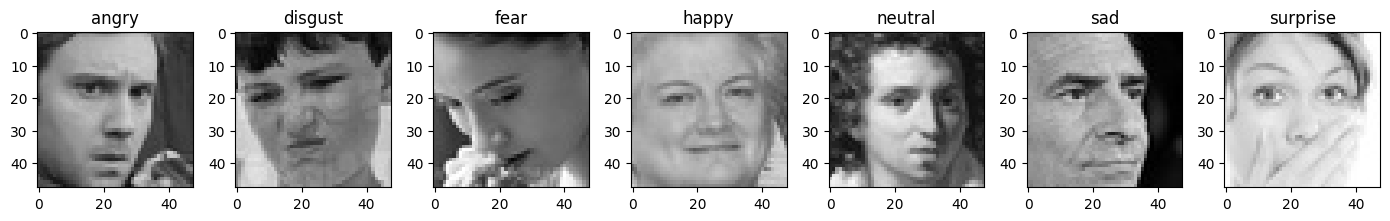

In [45]:
base_path = 'C:/Users/Admin/Documents/For_GitHub/Face_Emotion_Classifier_tfKeras/images/'

plt.figure(0, figsize=(14,3))
cpt = 0
for expression in os.listdir(base_path + 'train/'):
    for i in range(1):
        cpt = cpt + 1
        plt.subplot(1,7,cpt)
        img = load_img(base_path + 'train/' + expression + '/' +os.listdir(base_path + 'train/' + expression)[i], target_size=(PIC_SIZE, PIC_SIZE))
        plt.imshow(img, cmap='gray')
        plt.title(expression)

plt.tight_layout()
plt.show()

###### =============================================================================
## Model Architecture
###### =============================================================================

In [15]:
def build_cnn_model(input_shape=(PIC_SIZE, PIC_SIZE, 1), num_classes=7):
    """
    Build Keras CNN for emotion recognition.
    Architecture: 5 conv blocks + 3 dense layers with regularization.
    Input: 48x48x1 grayscale images.
    Output: 7-class softmax probabilities.
    """
    model = models.Sequential([
        # Block 1: 1->32->64
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),
        
        # Block 2: 64->128
        layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),
        
        # Block 3: 128->512
        layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),
        
        # Block 4: 512->512
        layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),
        
        # Block 5: 512->512
        layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        
        layers.Dense(num_classes, activation='softmax')  # Softmax for probabilities
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
# Instantiate and visualize model architecture
model = build_cnn_model()
model.summary()  

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,810,183 (22.16 MB)

 Trainable params: 5,805,191 (22.15 MB)

 Non-trainable params: 4,992 (19.50 KB)

###### =============================================================================
## Training Loop with Callbacks
###### =============================================================================

In [17]:
# Custom callback to save history as JSON after each epoch
class SaveHistoryCallback(Callback):
    def __init__(self, filepath):
        super().__init__()
        self.filepath = filepath
        self.history = {}
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.history.setdefault('loss', []).append(logs.get('loss'))
        self.history.setdefault('val_loss', []).append(logs.get('val_loss'))
        self.history.setdefault('accuracy', []).append(logs.get('accuracy'))
        self.history.setdefault('val_accuracy', []).append(logs.get('val_accuracy'))
        
        # Save after each epoch
        with open(self.filepath, 'w') as f:
            json.dump(self.history, f)
        
    def on_train_end(self, logs=None):
        # Final save
        with open(self.filepath, 'w') as f:
            json.dump(self.history, f)
        print(f'Full history saved to {self.filepath}')

In [18]:
# Callbacks for early stopping, checkpointing, and history saving
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        verbose=1,
        restore_best_weights=True,
        patience=PATIENCE
    ),
    ModelCheckpoint(
        MODEL_PATH,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    ),
    SaveHistoryCallback(HISTORY_PATH)  # History saver
]

In [19]:
# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.1699 - loss: 14.6922
Epoch 1: val_accuracy improved from None to 0.34754, saving model to best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 181s 391ms/step - accuracy: 0.1787 - loss: 14.2799 - val_accuracy: 0.3475 - val_loss: 13.1702
Epoch 2/50
151/450 ━━━━━━━━━━━━━━━━━━━━ 1:55 385ms/step - accuracy: 0.1949 - loss: 13.3662
Epoch 2: val_accuracy did not improve from 0.34754
450/450 ━━━━━━━━━━━━━━━━━━━━ 69s 153ms/step - accuracy: 0.2020 - loss: 13.2161 - val_accuracy: 0.3093 - val_loss: 12.7126
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.2146 - loss: 12.5434
Epoch 3: val_accuracy did not improve from 0.34754
450/450 ━━━━━━━━━━━━━━━━━━━━ 173s 385ms/step - accuracy: 0.2123 - loss: 12.1402 - val_accuracy: 0.3411 - val_loss: 10.9210
Epoch 4/50
151/450 ━━━━━━━━━━━━━━━━━━━━ 1:56 389ms/step - accuracy: 0.2186 - loss: 11.1548
Epoch 4: val_accuracy did not improve from 0.34754
450/450 ━━━━━━━━━━━━━━━━━━━━ 69s 

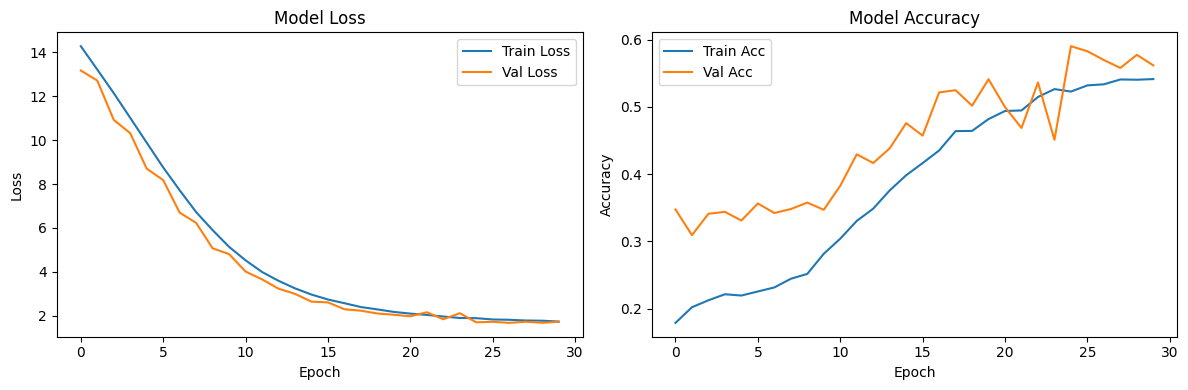

Final validation accuracy: 0.5905
Model saved to: best_model.keras
History also saved to: keras_history.json


In [24]:
# Plot training history (from fit, but also check JSON)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Acc')
plt.plot(history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

print(f'Final validation accuracy: {max(history["val_accuracy"]):.4f}')
print(f'Model saved to: {MODEL_PATH}')
print(f'History also saved to: {HISTORY_PATH}')